# Fitting a population of dust extinguished stars

This example shows how to fit a simulated population of dust extinghished stars to recover dust extinction properties.

## Specifying the MegaBEAST physics model

The MB physics model is specified using a python dictionary.  Here we specify it in two python dictonaries, one for the stellar part and one for the dust part, and then combine them into one for initializing the MB model.

The prior information can be used to fix a parameter so that it is not used.  This will be done for most of the MB parameters.

### Define MB physics model

In [1]:
import astropy.units as u

# all the parameters set to fixed will not be fit.  Any other information in the prior dictonary 
# is ignored (e.g., minmax).

# stellar population model
stellar_model = {
    "logA": {  # star formation history SFH
        "name": "bins_histo",
        "x": [6.0, 7.0, 8.0, 9.0, 10.0],  # units are log(years)
        "varnames": ["values"],
        "varinit": [[1e-8, 1e-8, 1e-8, 1e-8, 1e-8]],  # units are M_sun/year
        "prior": {
            "name": "fixed",
            "minmax": [[0.0, 0.0, 0.0, 0.0, 0.0], [1e-3, 1e-3, 1e-3, 1e-3, 1e-3]],
        },
    },
    "M_ini": {  # initial mass function - no parameters yet
        "name": "salpeter",
        "varnames": ["slope"],
        "varinit": [2.35],
        "prior": {
          "name": "fixed",
          "minmax": [[2.0, 3.0]],
        }
    },
    "Z": {
        "name": "flat",
        "prior": {
            "name": "fixed",
        }
    },    
    "distance": {  # no parameters yet
        "name": "absexponential",
        "varnames": ["dist0", "tau", "amp"],
        "varinit": [60.0 * u.kpc, 5. * u.kpc, 1.0],
        "prior": {
            "name": "fixed",
            "minmax": [[50.0, 3.0, 0.9], [70.0, 7.0, 1.1]],
        }
    },
}

# foreground dust cloud
dust_model = {
    "Av": {
        "name": "two_lognormal",
        "varnames": ["mean1", "mean2", "sigma1", "sigma2", "N1_to_N2"],
        "varinit": [0.1, 3.0, 0.2, 0.5, 2.0],
        "prior": {
            "name": "flat",
            "minmax": [[0.005, 5.0], [0.005, 5.0], [0.05, 1.0], [0.05, 1.0], [0.2, 2.0]],
        },
    },
    "Rv": {
        "name": "lognormal",
        "varnames": ["mean", "sigma"],
        "varinit": [3.1, 0.25],
        "prior": {
            "name": "fixed",
            # "name": "flat",
            "minmax": [[2.0, 6.0], [0.05, 1.0]],
        },
    },
    "f_A": {
        "name": "lognormal",
        "varnames": ["mean", "sigma"],
        "varinit": [1.0, 0.25],
        "prior": {
            "name": "fixed",
            # "name": "flat",
            "minmax": [[0.0, 1.0], [0.05, 0.5]],
        },
    }
}


### Inititalize MB model

In [2]:
from megabeast.mbmodel import MBModel

mod = MBModel(stellar_model, dust_model)

### Read in the needed BEAST information

In [3]:
from megabeast.helpers import read_beast_moddata, get_likelihoods

# BEAST files used by MegaBEAST
beast_base = "scylla_sim/scylla_sim"
physmodfile = beast_base + "_seds_trim.grid.hd5"
obsmodfile = beast_base + "_noisemodel.grid.hd5"

# get the BEAST physics and observation model info - only that needed for fitting
beast_moddata = read_beast_moddata(physmodfile, obsmodfile, mod.params)

scylla_sim_av01
[0.1, 0.3]
starting parameters
['Av_mean', 'Av_sigma']
[4.0, 0.5] -16675.945283288976


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [02:45<00:00,  3.01it/s]


final parameters
[0.102 0.365] -4187.432973020761

scylla_sim_av1
[1.0, 0.3]
starting parameters
['Av_mean', 'Av_sigma']
[4.0, 0.5] -8436.155420980678


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [02:47<00:00,  2.98it/s]


final parameters
[0.863 0.316] -3849.019629436419

scylla_sim_av3
[3.0, 0.3]
starting parameters
['Av_mean', 'Av_sigma']
[4.0, 0.5] -7648.42346437208


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [02:38<00:00,  3.15it/s]


final parameters
[2.437 0.251] -6508.895703808933

scylla_sim_avsig01
[1.0, 0.1]
starting parameters
['Av_mean', 'Av_sigma']
[4.0, 0.5] -9508.007735857944


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [02:22<00:00,  3.50it/s]


final parameters
[0.931 0.156] -4476.712191344824

scylla_sim_avsig05
[1.0, 0.5]
starting parameters
['Av_mean', 'Av_sigma']
[4.0, 0.5] -7596.591843895293


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [02:28<00:00,  3.37it/s]


final parameters
[0.818 0.466] -3494.6875992624223



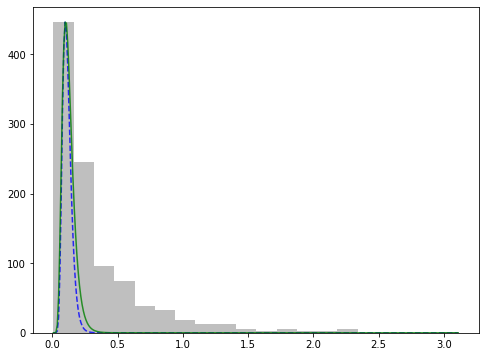

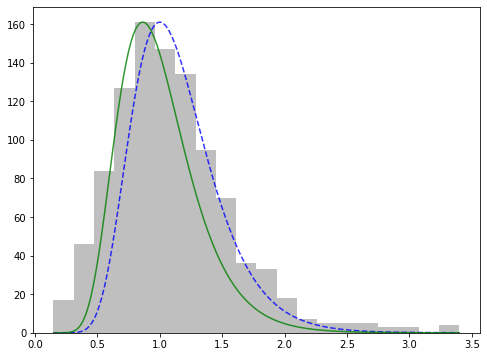

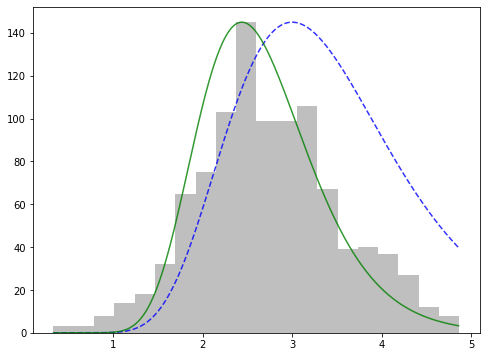

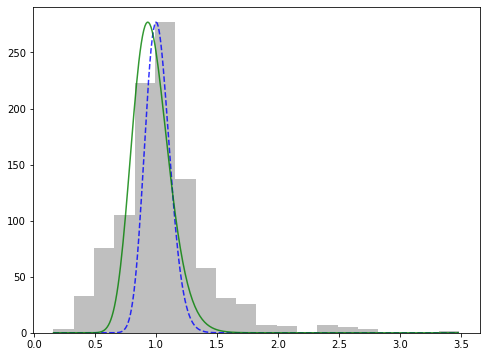

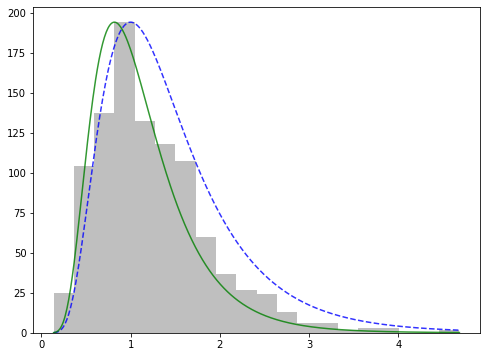

In [6]:
from astropy.table import QTable
import matplotlib.pyplot as plt
from beast.physicsmodel.priormodel_functions import _lognorm

import numpy as np
from megabeast.mbmodel import MBModel, fit_ensemble, lnprob

basenames = ["scylla_sim__av1", "scylla_sim_av1", "scylla_sim_av3",
             "scylla_sim_avsig01", "scylla_sim_avsig05"]
allorigparams = [[0.2, 3.0, 0.05, 0.5, 1.0]]
for k, basename in enumerate(basenames):
    mod.physics_model["Av"]["mean"] = 4.0
    mod.physics_model["Av"]["sigma"] = 0.5
    
    origparams = allorigparams[k]
    print(basename)
    print(origparams)
    
    lnpfile = f"scylla_sim_av_var/{basename}_lnp.hd5"

    # get the saved nD (sparse) likelihood multiplied by the grid_weight for each star
    star_lnpgriddata = get_likelihoods(lnpfile, beast_moddata)
    
    print("starting parameters")
    sparams = mod.start_params()
    print(sparams[0])
    print(
        sparams[1], lnprob(sparams[1], mod, star_lnpgriddata, beast_moddata)
    )

    # fit the model
    bestparams = fit_ensemble(mod, star_lnpgriddata, beast_moddata, nsteps=500)
    
    np.set_printoptions(precision=3)
    print("final parameters")
    print(
        bestparams, lnprob(bestparams, mod, star_lnpgriddata, beast_moddata)
    )
    print("")
    
    stats = QTable.read(f"scylla_sim_av_var/{basename}_stats.fits")

    plt.figure(figsize=(8, 6))
    hnpts, hbins, tmp = plt.hist(stats["Av_p50"], bins=20, alpha=0.25, label="BEAST Avs", color="black")

    modx = np.arange(np.min(hbins), np.max(hbins), 0.01)
    mody = _lognorm(modx, origparams[0], origparams[1])
    mody *= np.max(hnpts) / np.max(mody)
    plt.plot(modx, mody, "b--", alpha=0.8, label="sim MB model")

    modx = np.arange(np.min(hbins), np.max(hbins), 0.01)
    mody = _lognorm(modx, bestparams[0], bestparams[1])
    mody *= np.max(hnpts) / np.max(mody)
    plt.plot(modx, mody, "g-", alpha=0.8, label="MB fit")